# MARATONA BEHIND THE CODE 2020

## DESAFIO 4 - CompuSoluciones

### Introducción

En este desafío, CompuSoluciones usará herramientas de IBM como Watson Studio (o Cloud Pack for Data) y Watson Machine Learning para construir un modelo de Machine Learning natural capaz de predecir la probabilidad de cumplimiento de pago.

La idea esencial del Desafío 4 es crear un modelo basado en machine learning capaz de identificar el comportamiento financiero del asociado de negocio, permitiendo una probabilidad de cumplimiento o incumplimiento del crédito.

<hr>

### Instalación de Librerias

In [9]:
!pip install scikit-learn==0.20.3 --upgrade

Requirement already up-to-date: scikit-learn==0.20.3 in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.20.3)


In [10]:
# Si desea utilizar la biblioteca ** xgboost **, instale la versión 0.71.
#!pip install xgboost==0.71 --upgrade

In [1]:
import json
import requests
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

### Descargando el dataset csv desde Github

In [2]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv

--2020-08-25 19:30:00--  https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751735 (1.7M) [text/plain]
Saving to: ‘reto-4-compu-train.csv.1’

100%[======================================>] 1,751,735   --.-K/s   in 0.05s   

2020-08-25 19:30:00 (32.3 MB/s) - ‘reto-4-compu-train.csv.1’ saved [1751735/1751735]



In [3]:
df = pd.read_csv(r'reto-4-compu-train.csv')
df.head()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,OBJETIVO
0,NaN,7.710800e+06,NaN,1.237449e+06,2.947057e+05,8.812520e+06,4.547214e+07,239671.50090,1.257907e+06,2356497.733,-6.009930e+06,-6.816681e+06,41309820.53,6.872572e+07,6298390.104,1.505762e+07,Aceptado
1,7.437098e+04,2.213116e+06,NaN,1.335531e+05,4.000109e+05,8.491851e+06,1.573254e+07,94809.20697,6.708985e+05,NaN,-7.980962e+06,-3.342452e+06,NaN,3.588274e+07,NaN,1.085156e+07,Aceptado
2,5.269987e+06,2.893119e+07,3.983352e+05,1.533061e+07,3.478673e+06,-1.393229e+07,NaN,610814.63990,1.009937e+07,1444426.243,NaN,-4.026344e+06,NaN,3.292337e+08,NaN,8.680735e+06,Sospechoso
3,9.092134e+05,1.145092e+07,9.577823e+06,1.068692e+06,1.302021e+06,1.379064e+06,NaN,NaN,2.378928e+06,1236065.779,NaN,-4.567435e+06,76310275.60,NaN,NaN,1.323267e+07,Aceptado
4,9.688669e+05,8.539206e+06,3.898283e+06,4.168733e+05,NaN,-6.297179e+05,7.620711e+06,116647.73960,1.798065e+06,3657339.603,7.702845e+05,-7.110320e+05,62901614.29,3.614260e+07,6850340.403,1.100048e+07,Aceptado


### Acerca del Dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 17 columns):
EFECTIVO                     7986 non-null float64
CXC                          7968 non-null float64
INVENTARIO                   8000 non-null float64
EQ_OFICINA                   7945 non-null float64
EQ_TRANSPORTE                7988 non-null float64
TERRENOS_Y_CONSTRUCCIONES    8038 non-null float64
CXP                          7934 non-null float64
CONTRIBUCIONES_X_PAGAR       8052 non-null float64
ANTICIPOS_CTE                7976 non-null float64
CAP_SOCIAL                   8036 non-null float64
UTILIDADES_ACUMULADAS        7993 non-null float64
UTILIDAD_O_PERDIDA           8031 non-null float64
TOTAL_VENTAS                 7941 non-null float64
TOTAL_COMPRAS                7908 non-null float64
UTILIDAD_BRUTA               7971 non-null float64
TOTAL_GASTOS                 7943 non-null float64
OBJETIVO                     9400 non-null object
dtypes: float64(16), object

Las variables son todas numericas. Solo nuestra variable TARGET (Prestamo aprobado o posible incumplimiento financiero) es the tipo float.

La función describe() de abajo muestra varias estadisticas del dataset.

In [5]:
df.describe()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
count,7.986000e+03,7.968000e+03,8.000000e+03,7.945000e+03,7.988000e+03,8.038000e+03,7.934000e+03,8.052000e+03,7.976000e+03,8.036000e+03,7.993000e+03,8.031000e+03,7.941000e+03,7.908000e+03,7.971000e+03,7.943000e+03
mean,1.720915e+06,1.561073e+07,1.098941e+07,4.341284e+06,1.321588e+06,6.198420e+05,2.275234e+07,4.109997e+05,2.635145e+06,3.325138e+06,4.240122e+06,-2.090086e+06,1.017051e+08,1.211510e+08,1.702067e+07,1.620236e+07
std,5.958844e+06,1.980334e+07,1.541956e+07,1.885512e+07,1.398674e+06,6.202347e+06,2.810091e+07,6.311683e+05,3.828127e+06,4.122756e+06,1.066916e+07,2.439421e+06,1.148423e+08,3.320798e+08,1.710116e+07,1.341951e+07
min,2.591455e+03,3.282261e+01,5.019700e-02,2.974216e+02,1.698222e+02,-1.577708e+07,1.276200e+01,5.638191e+03,4.495763e+00,2.334091e+00,-4.029189e+07,-8.716171e+06,7.154203e+03,1.458903e+05,2.408107e+03,3.979024e+03
25%,1.874601e+05,2.362067e+06,9.281351e+05,1.769855e+05,3.433503e+05,-3.874056e+06,3.711720e+06,1.113298e+05,3.813363e+05,5.629920e+05,-3.025772e+06,-3.824858e+06,2.303181e+07,1.214764e+07,4.836037e+06,6.104123e+06
50%,5.112329e+05,8.255125e+06,4.810330e+06,6.529255e+05,8.630635e+05,1.828932e+06,1.286143e+07,2.288855e+05,1.235872e+06,1.870131e+06,4.119952e+06,-1.629044e+06,6.309045e+07,3.473485e+07,1.181114e+07,1.272461e+07
75%,1.432613e+06,2.160462e+07,1.474278e+07,2.430901e+06,1.827559e+06,5.955197e+06,3.097250e+07,4.690705e+05,3.273238e+06,4.536913e+06,1.140550e+07,-7.368186e+03,1.378293e+08,1.007433e+08,2.352766e+07,2.260017e+07
max,3.343603e+08,2.135761e+08,1.664338e+08,5.913821e+08,1.290365e+07,9.031323e+06,2.644946e+08,1.618323e+07,4.291686e+07,4.116688e+07,4.056842e+07,1.214191e+06,1.151511e+09,1.000136e+10,1.438985e+08,9.763166e+07


<hr>

### Entrenamiento y evaluación de un modelo de clasificación binaria


#### Transformación 1: excluir columnas del conjunto de datos

Para la creación de una transformación de datos personalizada en scikit-learn, es necesario crear una clase con los métodos transform y fit. En el método de 'transform', se ejecutará la lógica de nuestra transformación.

La siguiente celda muestra el código completo de una transformación DropColumns para eliminar columnas de un pandas DataFrame.


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        # Devolvemos un nuevo dataframe de datos sin las columnas no deseadas
        return data.drop(labels=self.columns, axis='columns')

In [7]:
# Creación de instancias de una transformación DropColumns
rm_columns = DropColumns(
    columns=[ 'EFECTIVO', 'CXC', 'INVENTARIO', 'EQ_OFICINA', 'EQ_TRANSPORTE',
       'TERRENOS_Y_CONSTRUCCIONES', 'CXP', 'CONTRIBUCIONES_X_PAGAR',
       'ANTICIPOS_CTE', 'CAP_SOCIAL']  # Esta transformación toma como parámetro una lista con los nombres de las columnas no deseadas
)

print(rm_columns)

DropColumns(columns=['EFECTIVO', 'CXC', 'INVENTARIO', 'EQ_OFICINA', 'EQ_TRANSPORTE', 'TERRENOS_Y_CONSTRUCCIONES', 'CXP', 'CONTRIBUCIONES_X_PAGAR', 'ANTICIPOS_CTE', 'CAP_SOCIAL'])


In [91]:
# Ver las columnas del conjunto de datos original
print("Columnas del conjunto de datos original: \n")
print(df.columns)

# Aplicar la transformación ``DropColumns`` al conjunto de datos base
rm_columns.fit(X=df)

# Reconstruyendo un DataFrame de Pandas con el resultado de la transformación
df2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df
    ),
)

# Ver las columnas del conjunto de datos transformado
print("\n\nColumnas del conjunto de datos después de la transformación ``DropColumns``: \n")
print(df2.columns)
df2.head()

Columnas del conjunto de datos original: 

Index(['EFECTIVO', 'CXC', 'INVENTARIO', 'EQ_OFICINA', 'EQ_TRANSPORTE',
       'TERRENOS_Y_CONSTRUCCIONES', 'CXP', 'CONTRIBUCIONES_X_PAGAR',
       'ANTICIPOS_CTE', 'CAP_SOCIAL', 'UTILIDADES_ACUMULADAS',
       'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS', 'TOTAL_COMPRAS', 'UTILIDAD_BRUTA',
       'TOTAL_GASTOS', 'OBJETIVO'],
      dtype='object')


Columnas del conjunto de datos después de la transformación ``DropColumns``: 

Index(['UTILIDADES_ACUMULADAS', 'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS',
       'TOTAL_COMPRAS', 'UTILIDAD_BRUTA', 'TOTAL_GASTOS', 'OBJETIVO'],
      dtype='object')


,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,OBJETIVO
0,-6.009930e+06,-6.816681e+06,41309820.53,6.872572e+07,6298390.104,1.505762e+07,Aceptado
1,-7.980962e+06,-3.342452e+06,NaN,3.588274e+07,NaN,1.085156e+07,Aceptado
2,NaN,-4.026344e+06,NaN,3.292337e+08,NaN,8.680735e+06,Sospechoso
3,NaN,-4.567435e+06,76310275.60,NaN,NaN,1.323267e+07,Aceptado
4,7.702845e+05,-7.110320e+05,62901614.29,3.614260e+07,6850340.403,1.100048e+07,Aceptado


#### Transformación 2: estandarización de Features

#### Definición de features (Variables Independientes)

En este * ejemplo * usaremos todas las columnas. (Usted debe decidir cuales variables utilizar)

#### División en 80% entrenamiento y 20% pruebas

#### Transformación 3: tratamiento de datos faltantes

Para manejar los datos que faltan en nuestro conjunto de datos, ahora usaremos una transformación lista para usar de la biblioteca scikit-learn, llamada SimpleImputer.

Esta transformación permite varias estrategias para el tratamiento de datos faltantes. La documentación oficial se puede encontrar en: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

En este ejemplo, simplemente haremos cero todos los valores faltante usted puede escoger otra estrategia ;).

In [98]:
# Crear un objeto ``SimpleImputer``
si = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy='most_frequent',  # la estrategia elegida es cambiar el valor faltante por una constante
    verbose=0,
)

print(si)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)


In [112]:
# Ver los datos faltantes del conjunto de datos antes de la primera transformación (df_data_2)
#print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df2.isnull().sum(axis = 0)))
df2=np.array(df2)
# Aplicamos el SimpleImputer ``si`` al conjunto de datos df_data_2 (resultado de la primera transformación)
si=si.fit(df2[::-1])

 #Reconstrucción de un nuevo DataFrame de Pandas con el conjunto imputado (df_data_3)
df3 = pd.DataFrame.from_records(
    data=si.transform(
        df2[::-1]
   ),  # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista

# las columnas originales deben conservarse en esta transformación
)

# Ver los datos faltantes del conjunto de datos después de la segunda transformación (SimpleImputer) (df_data_3)
print("\n\nValores nulos en el conjunto de datos después de la transformación SimpleImputer: \n\n{}\n".format(df3.sum(axis = 0)))



Valores nulos en el conjunto de datos después de la transformación SimpleImputer: 

0                                         -2.27994e+10
1                                         -2.87179e+10
2                                          8.07651e+11
3                                           9.5828e+11
4                                          1.35675e+11
5                                          1.28701e+11
6    AceptadoAceptadoAceptadoSospechosoAceptadoSosp...
dtype: object



In [113]:
df3.columns=['UTILIDADES_ACUMULADAS',
       'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS', 'TOTAL_COMPRAS', 'UTILIDAD_BRUTA',
       'TOTAL_GASTOS','OBJETIVO']
print(df3.columns)
df3.head()

Index(['UTILIDADES_ACUMULADAS', 'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS',
       'TOTAL_COMPRAS', 'UTILIDAD_BRUTA', 'TOTAL_GASTOS', 'OBJETIVO'],
      dtype='object')


,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,OBJETIVO
0,-4.029189e+07,-2486727.744,1.122458e+08,1.136379e+08,22303696.39,26172747.54,Aceptado
1,1.036295e+06,-1710693.486,7.154203e+03,1.079290e+08,33875162.34,33678877.65,Aceptado
2,6.787283e+06,-8716171.436,8.408760e+07,2.220056e+08,14722995.91,24415528.51,Aceptado
3,1.974726e+07,-6242070.631,1.114211e+08,1.004731e+08,12885083.17,10916813.86,Sospechoso
4,6.505209e+06,-1340405.857,1.316208e+08,1.458903e+05,42130695.21,51144931.69,Aceptado


In [114]:
# Definiendo las variables features y target (removed CXC and CXP)

features = df3[
    [
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
]
target = df3["OBJETIVO"]  ## No cambie la variable target!

In [115]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=None)

In [116]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Entrenando un modelo ``DecisionTreeClassifier()``

In [118]:
# Método para creacion de modelos basados en arbol de desición
#from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

dtc = GaussianNB()
model = dtc.fit(X_train, y_train)

#### Haciendo una predicción con el set de prueba

In [119]:
y_pred = dtc.predict(X_test)
print(y_pred)

['Aceptado' 'Sospechoso' 'Aceptado' ... 'Aceptado' 'Aceptado' 'Aceptado']


#### Analizar la calidad del modelo a través de la matriz de confusión

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.898\nPrecision=0.212\nRecall=0.387\nF1 Score=0.2737642585551331')

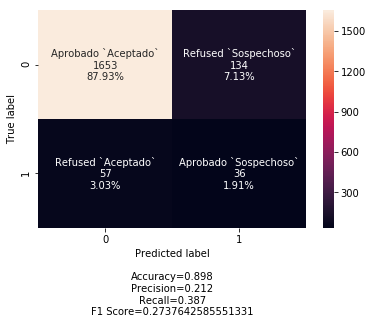

In [120]:

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

##### ¡ATENCIÓN! Su puntuación en este desafío de clasificación se basará en la puntuación F1 del modelo.

<hr>

### Construcción del Pipeline completo para el encapsulamiento en WML

#### Preparando transformaciones personalizadas para cargar en WML

En el reto 2 (Tortuga Code), se mostró cómo crear una transformación personalizada, declarando una clase Python con los métodos ``fit`` y ``transform``.

    - Código de transformación personalizada DropColumns():
    
    from sklearn.base import BaseEstimator, TransformerMixin
    # All sklearn Transforms must have the `transform` and `fit` methods
    class DropColumns(BaseEstimator, TransformerMixin):
        def __init__(self, columns):
            self.columns = columns
        def fit(self, X, y=None):
            return self
        def transform(self, X):
            # Primero copiamos el dataframe de entrada 'X' de entrada
            data = X.copy()
            # Devolvemos un nuevo marco de datos sin las columnas no deseadas
            return data.drop(labels=self.columns, axis='columns')

Para integrar estos tipos de transformaciones personalizadas con Pipelines en Watson Machine Learning, primero debe empaquetar su código personalizado como una biblioteca de Python. Esto se puede hacer fácilmente usando la herramienta *setuptools*.

En el siguiente repositorio de git: https://github.com/vnderlev/sklearn_transforms tenemos todos los archivos necesarios para crear un paquete de Python, llamado **my_custom_sklearn_transforms**.
Este paquete tiene la siguiente estructura de archivos:

    /my_custom_sklearn_transforms.egg-info
        dependency_links.txt
        not-zip-safe
        PKG-INFO
        SOURCES.txt
        top_level.txt
    /my_custom_sklearn_transforms
        __init__.py
        sklearn_transformers.py
    PKG-INFO
    README.md
    setup.cfg
    setup.py
    
El archivo principal, que contendrá el código para nuestras transformaciones personalizadas, es el archivo **/my_custom_sklearn_transforms/sklearn_transformers.py**. Si accedes a él en el repositorio, notarás que contiene exactamente el mismo código declarado en el primer paso (la clase DropColumns).

Si has declarado sus propias transformaciones (además de la DropColumn proporcionada), debes agregar todas las clases de esas transformaciones creadas en este mismo archivo. Para hacer esto, debes hacer fork de este repositorio (esto se puede hacer en la propia interfaz web de Github, haciendo clic en el botón como se muestra en la imagen a continuación) y agregue sus clases personalizadas al archivo **sklearn_transformers.py**.

![alt text](https://i.imgur.com/2lZ4Ty2.png "forking-a-repo")

Si solo hizo uso de la transformación proporcionada (DropColumns), puede omitir este paso de fork y continuar usando el paquete base provisto. :)

Después de preparar su paquete de Python con sus transformaciones personalizadas, reemplace el enlace del repositorio de git en la celda a continuación y ejecútelo. Si no ha preparado ninguna transformación nueva, ejecute la celda con el enlace del repositorio ya proporcionado.

<hr>
    
**OBSERVACIÓN**

Si la ejecución de la celda a continuación devuelve un error de que el repositorio ya existe, ejecute:

**!rm -r -f sklearn_transforms**

In [121]:
# Susbtituya el link de abajo por el link de su repositorio git (se es necesario)
!git clone https://github.com/vnderlev/sklearn_transforms.git

Cloning into 'sklearn_transforms'...
remote: Enumerating objects: 59, done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 59
Unpacking objects: 100% (59/59), done.


In [122]:
!cd sklearn_transforms
!ls -ltr

total 3428
-rw-r----- 1 dsxuser dsxuser 1751735 Aug 25 18:37 reto-4-compu-train.csv
-rw-r----- 1 dsxuser dsxuser 1751735 Aug 25 19:30 reto-4-compu-train.csv.1
drwxr-x--- 5 dsxuser dsxuser    4096 Aug 25 21:02 sklearn_transforms


Para subir o código no WML, precisamos enviar um arquivo .zip com todo o código fonte, então iremos zipar o diretório clonado em seguida:

In [123]:
!zip -r sklearn_transforms.zip sklearn_transforms

  adding: sklearn_transforms/ (stored 0%)
  adding: sklearn_transforms/setup.py (deflated 46%)
  adding: sklearn_transforms/.git/ (stored 0%)
  adding: sklearn_transforms/.git/description (deflated 14%)
  adding: sklearn_transforms/.git/hooks/ (stored 0%)
  adding: sklearn_transforms/.git/hooks/pre-applypatch.sample (deflated 36%)
  adding: sklearn_transforms/.git/hooks/update.sample (deflated 68%)
  adding: sklearn_transforms/.git/hooks/prepare-commit-msg.sample (deflated 46%)
  adding: sklearn_transforms/.git/hooks/pre-rebase.sample (deflated 59%)
  adding: sklearn_transforms/.git/hooks/pre-commit.sample (deflated 46%)
  adding: sklearn_transforms/.git/hooks/commit-msg.sample (deflated 44%)
  adding: sklearn_transforms/.git/hooks/applypatch-msg.sample (deflated 41%)
  adding: sklearn_transforms/.git/hooks/post-update.sample (deflated 27%)
  adding: sklearn_transforms/.git/hooks/pre-push.sample (deflated 50%)
  adding: sklearn_transforms/.git/HEAD (stored 0%)
  adding: sklearn_transfo

Con el archivo zip de nuestro paquete cargado en el Kernel de este notebook, podemos utiliar la herramienta pip para instalarlo conforme a la siguiente celda:

In [124]:
!pip install sklearn_transforms.zip

Processing ./sklearn_transforms.zip
  Stored in directory: /home/dsxuser/.tmp/pip-ephem-wheel-cache-lnhh4lcq/wheels/8f/88/32/f886e7510a37b111e2a1b7e689e04450acda46732970a7ed78
Successfully built my-custom-sklearn-transforms


Ahora podemos realizar la importación de nuestro paquiete personalizado en nuestro notabook!

Vamos a importan la transformación DropColumns. Si usted posee otras transformaciones personalizadas, ahora es que debe importarlas

In [125]:
from my_custom_sklearn_transforms.sklearn_transformers import DropColumns

## Construyendo el model Pipeline

# ATENCIÓN, NO CAMBIE LA CELDA DE ABAJO O SU MODELO NO SERA EVALUADO

In [126]:
pipeline_input = df[
    [
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
]

pipeline_target = df['OBJETIVO']

In [127]:
# Separación de los datos en un set de entrenamiento y otro de prueba (PARA CREACION DEL PIPELINE)
X_train, X_test, y_train, y_test = train_test_split(
    pipeline_input,
    pipeline_target,
    test_size=0.3,
    random_state=21233
)

### Borrando las columnas del dataset original

Debe elminiar todas las columnas que no esta usando

In [128]:
# Creacion de la Transformación Personalizada ``DropColumns``

rm_columns = DropColumns(
    columns=[ 'EFECTIVO', 'CXC', 'INVENTARIO', 'EQ_OFICINA', 'EQ_TRANSPORTE',
       'TERRENOS_Y_CONSTRUCCIONES', 'CXP', 'CONTRIBUCIONES_X_PAGAR',
       'ANTICIPOS_CTE', 'CAP_SOCIAL']
)

### Reemplazando con zeros en lugar de valores nulos

Ud puede usar otras estrategias, pero deben ser con Transforms

In [129]:
# Crear un objeto ``SimpleImputer``
si = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy='most_frequent',  # la estrategia elegida es cambiar el valor faltante por una constante
    verbose=0,
)

### Estandarizando los valores numericos

In [130]:
sc = StandardScaler()

### Pre-entrenando el modelo para definir el pipeline

En la celda de abajo se declara un objeto **Pipeline** de scikit-learn, donde es declarado como parametros *steps*, que es una lista de etapas a ejecutar el pipeline:

    'paso_1_remove_cols'     - Transformación personalizada DropColumns
    'paso_2_imputer'         - Transformación embebida de scikit-learn para remplazar los valores faltantes
    'paso_3_standard_scaler'          - Transformación embebida de scikit-learn para escalar las variables numéricas
    'su_modelo'              - Un árbol de desición simple
    
Note que pasamos como pasos las transformaciones instanciadas anteriormente, con nombres `rm_columns` y `si`.

In [134]:
# Creación de nuestro para almacenamiento en Watson Machine Learning:
my_pipeline = Pipeline(
    steps=[
        ('paso_1_remove_cols', rm_columns),
        ('paso_2_imputer', si),
        ('paso_3_standard_scaler', sc),
        ('su_modelo',GaussianNB()),
    ]
)

En seguida ejecutaremos el método `fit()` del Pipeline, realizando el pré-procesamiento y el entrenamiento del modelo de una sola vez.

In [135]:
# Inicializando el Pipeline (pre-procesamiento y entrenamiento del modelo)
my_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('paso_1_remove_cols', DropColumns(columns=['EFECTIVO', 'CXC', 'INVENTARIO', 'EQ_OFICINA', 'EQ_TRANSPORTE', 'TERRENOS_Y_CONSTRUCCIONES', 'CXP', 'CONTRIBUCIONES_X_PAGAR', 'ANTICIPOS_CTE', 'CAP_SOCIAL'])), ('paso_2_imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)), ('paso_3_standard_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('su_modelo', GaussianNB(priors=None, var_smoothing=1e-09))])

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.904\nPrecision=0.250\nRecall=0.340\nF1 Score=0.288')

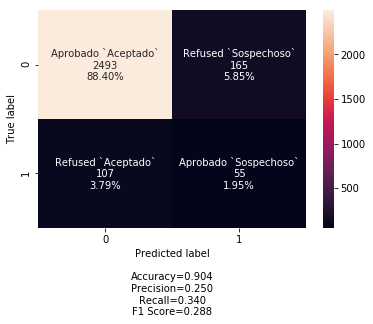

In [136]:
### Haciendo una predicción con el set de prueba

y_pred = my_pipeline.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

In [137]:
# Precisión simple
my_pipeline.score(X_test, y_test)

0.9035460992907801

Ahora que tenemos un Pipeline completo, con etapas de pre-procesamiento configuradas y tambien un modelo por Árbol de Desición entrenado, podemos realizar la integración con Watson Machine Learning!

<hr>

### Encapsulando un Pipeline personalizado de Watson Machine Learning

#### Estableciendo conexión entre el cliente Python de WML y su instancia del servicio en la nube

In [138]:
# Biblioteca Python con implementación de un cliente HTTP para la API de WML
from watson_machine_learning_client import WatsonMachineLearningAPIClient

2020-08-25 21:11:15,099 - watson_machine_learning_client.wml_client_error - WARNING - Failure during getting all runtimes. (GET https://us-south.ml.cloud.ibm.com/v4/runtimes?limit=1000)
Status code: 404, body: {"trace":"h7dbqm4jcsbx","errors":[{"code":"not_found","message":"Requested object b78f18bf-94ae-41e7-b922-9c2cf2098a3e could not be found."}]}
2020-08-25 21:11:15,103 - watson_machine_learning_client.repository - ERROR - Failure during getting all runtimes. (GET https://us-south.ml.cloud.ibm.com/v4/runtimes?limit=1000)
Status code: 404, body: {"trace":"h7dbqm4jcsbx","errors":[{"code":"not_found","message":"Requested object b78f18bf-94ae-41e7-b922-9c2cf2098a3e could not be found."}]}
2020-08-25 21:13:03,117 - watson_machine_learning_client.wml_client_error - WARNING - Failure during getting runtime specs details. (GET https://us-south.ml.cloud.ibm.com/v4/runtimes)
Status code: 404, body: {"trace":"-1ske8k9szaoq9","errors":[{"code":"not_found","message":"Requested object b78f18bf-9

Las próximas celdas realizaran el despliegue del pipeline declarada en este notebook en WML. Solo prosiga si usted ya está satisfecho con su modelo y cree que ya es hora de hacer el despliegue de su solución.

Copie las credenciales de su instancia de Watson Machine Learning en la variable de la celda de abajo.

Es importante que la variable que contenga los valores de la credencial se llame ``wml_credentials`` para que las proximas celdas de este notebook se ejecuten corretamente.

In [139]:
wml_credentials = {
  "apikey": "mO9eeIGjcDsCT0RC2CADyJuCmfKCrIlIo1e3RsToVbuJ",
  "iam_apikey_description": "Auto-generated for key 385a9d77-af63-43ea-b52c-9d6e19ed9d8a",
  "iam_apikey_name": "Credenciales de servicio-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/ade10afa8c764ebcb7184cc3801f0edb::serviceid:ServiceId-719eb510-d940-4a2c-82c3-763e43ef3e12",
  "instance_id": "acde55a6-e981-4899-8e70-8af87d9dd908",
  "url": "https://us-south.ml.cloud.ibm.com"
}

In [140]:
# Instanciando un objeto cliente de Watson Machine Learning a partir de las credenciales

clientWML = WatsonMachineLearningAPIClient(wml_credentials)

In [141]:
# Extrayendo los detalles de su de Watson Machine Learning

instance_details = clientWML.service_instance.get_details()
print(json.dumps(instance_details, indent=4))

{
    "entity": {
        "source": "Bluemix",
        "published_models": {
            "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/acde55a6-e981-4899-8e70-8af87d9dd908/published_models"
        },
        "usage": {
            "capacity_units": {
                "current": 0,
                "limit": 180000000
            },
            "computation_time": {
                "current": 0,
                "limit": 180000
            },
            "deployment_count": {
                "current": 2,
                "limit": 5
            },
            "expiration_date": "2020-09-01T00:00:00.000Z",
            "gpu_count_k80": {
                "current": 0,
                "limit": 8
            },
            "gpu_count_p100": {
                "current": 0,
                "limit": 0
            },
            "gpu_count_v100": {
                "current": 0,
                "limit": 0
            },
            "model_count": {
                "current": 1,
         

**¡¡ATENCIÓN!!**

¡Este atento de los limites de consumo de su instancia de Watson Machine Learning!

En caso de que acabe la capa gratuita, no sera posible evualuar su modelo (Pues es necesario para la realización de algunas llamadasal API con sus predicciones!)

#### Listando todos los artefatos almacenados en su WML

Para listar todos los artefatos almacenados en su Watson Machine Learning, usted puede usar la seguinte función:

    clientWML.repository.list()

In [142]:
# Listando todos los artefatos actualmente almacenados en su instancia de WML

clientWML.repository.list()

------------------------------------  ----------------------------------  ------------------------  -----------------  -----------------
GUID                                  NAME                                CREATED                   FRAMEWORK          TYPE
a00d8664-6c0b-484e-b8af-c7eba15f7fdf  desafio-2-mbtc2020-pipeline-es-2    2020-08-22T18:48:23.310Z  scikit-learn-0.20  model
58e41b49-e462-46f1-b390-8d9c7d109894  desafio-2-mbtc2020-deployment-es-2  2020-08-22T18:48:50.233Z  scikit-learn-0.20  online deployment
6ff1960d-6913-4e08-940e-3a79383a03f6  my_custom_sklearn_transform_es_2    2020-08-22T18:43:57.565Z  -                  python library
------------------------------------  ----------------------------------  ------------------------  -----------------  -----------------


## ATENCIÓN!, SI UD CORRE LAS CELDAS DE ABAJO TODOS LOS DESPLIEGUES ANTERIORS SERAN BORRADOS

In [146]:
#Celda para borrar los Deployments:

for uid in clientWML.deployments.get_uids():
    if clientWML.deployments.get_details(uid)['entity']['name'] == 'deployment_meta_4' : 
        print('Deleted ' + clientWML.deployments.get_details(uid)['entity']['name'] )
        clientWML.deployments.delete(uid)

In [147]:
#Celda para borrar todos los recursos:

d = clientWML.repository.get_details()
for k in d:
    for res in d[k]["resources"]:
        if res['entity']['name'] in ['package_meta_4', 'runtime_meta_4', 'pipeline_meta_4']:
            clientWML.repository.delete(res["metadata"]["guid"])
            print('Deleted ' + res['entity']['name'])

ApiRequestFailure: Failure during getting runtime specs details. (GET https://us-south.ml.cloud.ibm.com/v4/runtimes)
Status code: 404, body: {"trace":"17ndeojiaj8p0","errors":[{"code":"not_found","message":"Requested object b78f18bf-94ae-41e7-b922-9c2cf2098a3e could not be found."}]}

In [148]:
# Listando todos los artefatos actualmente almacenados en su instancia de WML

clientWML.repository.list()

------------------------------------  ----------------------------------  ------------------------  -----------------  -----------------
GUID                                  NAME                                CREATED                   FRAMEWORK          TYPE
a00d8664-6c0b-484e-b8af-c7eba15f7fdf  desafio-2-mbtc2020-pipeline-es-2    2020-08-22T18:48:23.310Z  scikit-learn-0.20  model
58e41b49-e462-46f1-b390-8d9c7d109894  desafio-2-mbtc2020-deployment-es-2  2020-08-22T18:48:50.233Z  scikit-learn-0.20  online deployment
6ff1960d-6913-4e08-940e-3a79383a03f6  my_custom_sklearn_transform_es_2    2020-08-22T18:43:57.565Z  -                  python library
------------------------------------  ----------------------------------  ------------------------  -----------------  -----------------


#### Creando una nueva definición de paquete Python personalizado en WML

El primer paso para realizar su deploy y almacenar el código de las transformaciones personalizadas creadas por usted.

Para esta etapa solo necesitamos el archivo .zip del paquete creado por usted (Que ya tenemos cargados en el Kernel!)

In [149]:
# Definición de metadatos del paquete con las Transformaciones personalizadas
pkg_meta = {
    clientWML.runtimes.LibraryMetaNames.NAME: "package_meta_4",
    clientWML.runtimes.LibraryMetaNames.DESCRIPTION: "A custom sklearn transform package",
    clientWML.runtimes.LibraryMetaNames.FILEPATH: "sklearn_transforms.zip",  # Note que estamos utilizando o .zip criado anteriormente!
    clientWML.runtimes.LibraryMetaNames.VERSION: "1.0",
    clientWML.runtimes.LibraryMetaNames.PLATFORM: { "name": "python", "versions": ["3.6"] }
}
custom_package_details = clientWML.runtimes.store_library( pkg_meta )
custom_package_uid = clientWML.runtimes.get_library_uid( custom_package_details )

print("\n Lista de artefactos de runtime almacenados en WML:")
clientWML.repository.list()


 Lista de artefactos de runtime almacenados en WML:
------------------------------------  ----------------------------------  ------------------------  -----------------  -----------------
GUID                                  NAME                                CREATED                   FRAMEWORK          TYPE
a00d8664-6c0b-484e-b8af-c7eba15f7fdf  desafio-2-mbtc2020-pipeline-es-2    2020-08-22T18:48:23.310Z  scikit-learn-0.20  model
58e41b49-e462-46f1-b390-8d9c7d109894  desafio-2-mbtc2020-deployment-es-2  2020-08-22T18:48:50.233Z  scikit-learn-0.20  online deployment
04b0573d-1e5f-4a24-86a0-db389a97bc80  package_meta_4                      2020-08-25T21:17:22.325Z  -                  python library
6ff1960d-6913-4e08-940e-3a79383a03f6  my_custom_sklearn_transform_es_2    2020-08-22T18:43:57.565Z  -                  python library
------------------------------------  ----------------------------------  ------------------------  -----------------  -----------------


#### Creando una nueva definición de runtime Python personalizado en WML

El segundo paso es almacenar una definición de runtime Python para utilizar en nuestra biblioteca personalizada.

Esto puede hacerse de la siguiente manera:

In [150]:
runtime_meta = {
    clientWML.runtimes.ConfigurationMetaNames.NAME: "runtime_meta_4",
    clientWML.runtimes.ConfigurationMetaNames.DESCRIPTION: "A Python runtime with custom sklearn Transforms",
    clientWML.runtimes.ConfigurationMetaNames.PLATFORM: {
        "name": "python",
        "version": "3.6"
    },
    clientWML.runtimes.ConfigurationMetaNames.LIBRARIES_UIDS: [ custom_package_uid ]
}
runtime_details = clientWML.runtimes.store( runtime_meta )
custom_runtime_uid = clientWML.runtimes.get_uid( runtime_details )

print("\n Detalles del runtime almacenados:")
print(json.dumps(runtime_details, indent=4))


 Detalles del runtime almacenados:
{
    "entity": {
        "name": "runtime_meta_4",
        "description": "A Python runtime with custom sklearn Transforms",
        "custom_libraries": [
            {
                "name": "package_meta_4",
                "url": "https://private.us-south.ml.cloud.ibm.com/v4/libraries/04b0573d-1e5f-4a24-86a0-db389a97bc80",
                "version": "1.0"
            }
        ],
        "content_url": "https://private.us-south.ml.cloud.ibm.com/v4/runtimes/e52c83c6-8b81-4415-8fd0-ccc7810988a8/content",
        "platform": {
            "name": "python",
            "version": "3.6"
        }
    },
    "metadata": {
        "created_at": "2020-08-25T21:17:47.727Z",
        "guid": "e52c83c6-8b81-4415-8fd0-ccc7810988a8",
        "url": "https://us-south.ml.cloud.ibm.com/v4/runtimes/e52c83c6-8b81-4415-8fd0-ccc7810988a8"
    }
}


In [151]:
# Listando todos los runtimes almacenados en su WML:
clientWML.runtimes.list()

ApiRequestFailure: Failure during getting runtime specs details. (GET https://us-south.ml.cloud.ibm.com/v4/runtimes)
Status code: 404, body: {"trace":"-1rk94agttage9","errors":[{"code":"not_found","message":"Requested object b78f18bf-94ae-41e7-b922-9c2cf2098a3e could not be found."}]}

#### Creando una nueva definición de Pipeline personalizado en WML

Finalmente creando una definición (metadatos) para que nuestro Pipeline sea hospedada en WML.

Definimos como parametros el nombre para el artefacto y el ID de runtime creado anteriormente.

In [152]:
model_meta = {
    clientWML.repository.ModelMetaNames.NAME: 'pipeline_meta_4',
    clientWML.repository.ModelMetaNames.DESCRIPTION: "my pipeline for submission",
    clientWML.repository.ModelMetaNames.RUNTIME_UID: custom_runtime_uid
}

En seguida llamamos el método para almacenar una nueva definición:

In [153]:
# Función para almacenar una definición de Pipeline en WML
stored_model_details = clientWML.repository.store_model(
    model=my_pipeline,  # `my_pipeline` es la variable creada anteriormente que contiene nuestro Pipeline ya entrenado :)
    meta_props=model_meta,  # Metadatos definidos en la celda anterior
    training_data=None  # No altere este parametro
)

print("\n Lista de artefatos almacenados en WML:")
clientWML.repository.list()

# Datalles del modelo hospedado en Watson Machine Learning
print("\n Metadatos del modelo almacenado:")
print(json.dumps(stored_model_details, indent=4))


 Lista de artefatos almacenados en WML:
------------------------------------  ----------------------------------  ------------------------  -----------------  -----------------
GUID                                  NAME                                CREATED                   FRAMEWORK          TYPE
ffeea340-e94c-47d5-8b52-c3a14f3d234a  pipeline_meta_4                     2020-08-25T21:19:20.907Z  scikit-learn-0.20  model
a00d8664-6c0b-484e-b8af-c7eba15f7fdf  desafio-2-mbtc2020-pipeline-es-2    2020-08-22T18:48:23.310Z  scikit-learn-0.20  model
58e41b49-e462-46f1-b390-8d9c7d109894  desafio-2-mbtc2020-deployment-es-2  2020-08-22T18:48:50.233Z  scikit-learn-0.20  online deployment
04b0573d-1e5f-4a24-86a0-db389a97bc80  package_meta_4                      2020-08-25T21:17:22.325Z  -                  python library
6ff1960d-6913-4e08-940e-3a79383a03f6  my_custom_sklearn_transform_es_2    2020-08-22T18:43:57.565Z  -                  python library
------------------------------------  -----

#### Realizando un deployment de su modelo para consumo inmediato por otras aplicaciones

In [154]:
# El deployment del modelo es finalmente realizado por medio del método ``deployments.create()``

model_deployment_details = clientWML.deployments.create(
    artifact_uid=stored_model_details["metadata"]["guid"],  # No altere este parametro
    name="deployment_meta_4",
    description="Desafio 4 MBTC",
    asynchronous=False,  # No altere este parametro
    deployment_type='online',  # No altere este parametro
    deployment_format='Core ML',  # No altere este parametro
    meta_props=model_meta  # No altere este parametro
)



#######################################################################################

Synchronous deployment creation for uid: 'ffeea340-e94c-47d5-8b52-c3a14f3d234a' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS..
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='9c0e60e8-db2f-48a9-bfd7-37f1e4ab7728'
------------------------------------------------------------------------------------------------




#### Probando el modelo hospedado en Watson Machine Learning

In [155]:
# Recuperando la URL endpoint dl modelo hospedado en la celda anterior

model_endpoint_url = clientWML.deployments.get_scoring_url(model_deployment_details)
print("La URL de llamada de su API es: {}".format(model_endpoint_url))

La URL de llamada de su API es: https://us-south.ml.cloud.ibm.com/v3/wml_instances/acde55a6-e981-4899-8e70-8af87d9dd908/deployments/9c0e60e8-db2f-48a9-bfd7-37f1e4ab7728/online


### ATENCIÓN: UD necesitará de la URL de arriba para entregar su modelo :)

In [156]:
# Detalles del deployment realizado

deployment_details = clientWML.deployments.get_details(
    deployment_uid=model_deployment_details["metadata"]["guid"]  # Este es el ID de su deployment!
)

print("Metadatos del deployment realizado: \n")
print(json.dumps(deployment_details, indent=4))

Metadatos del deployment realizado: 

{
    "metadata": {
        "guid": "9c0e60e8-db2f-48a9-bfd7-37f1e4ab7728",
        "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/acde55a6-e981-4899-8e70-8af87d9dd908/deployments/9c0e60e8-db2f-48a9-bfd7-37f1e4ab7728",
        "created_at": "2020-08-25T21:19:38.067Z",
        "modified_at": "2020-08-25T21:19:38.696Z"
    },
    "entity": {
        "runtime_environment": "python-3.6",
        "name": "deployment_meta_4",
        "scoring_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/acde55a6-e981-4899-8e70-8af87d9dd908/deployments/9c0e60e8-db2f-48a9-bfd7-37f1e4ab7728/online",
        "deployable_asset": {
            "name": "pipeline_meta_4",
            "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/acde55a6-e981-4899-8e70-8af87d9dd908/published_models/ffeea340-e94c-47d5-8b52-c3a14f3d234a",
            "guid": "ffeea340-e94c-47d5-8b52-c3a14f3d234a",
            "description": "my pipeline for submission",
      

### Realizando una llamada de API para su modelo almacenado en WML

In [157]:
scoring_payload = {
    'fields': [
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ],
    'values': [
        [
            968866.8993,
            102102.000,
            8539205.63,
            3898282.548,
            416873.3265,
            1420050.089,
            -629717.8548,
            14613560.64,
            7620711.462,
            116647.7396,
            1798064.624,
            9535423.826,
            3657339.603,
            770284.5004,
            -102101.201,
            -711032.0155
        ]
    ]
}

print("\n Payload de datos a ser clasificado:")
print(json.dumps(scoring_payload, indent=4))


 Payload de datos a ser clasificado:
{
    "fields": [
        "EFECTIVO",
        "CXC",
        "INVENTARIO",
        "EQ_OFICINA",
        "EQ_TRANSPORTE",
        "TERRENOS_Y_CONSTRUCCIONES",
        "CXP",
        "CONTRIBUCIONES_X_PAGAR",
        "ANTICIPOS_CTE",
        "CAP_SOCIAL",
        "UTILIDADES_ACUMULADAS",
        "UTILIDAD_O_PERDIDA",
        "TOTAL_VENTAS",
        "TOTAL_COMPRAS",
        "UTILIDAD_BRUTA",
        "TOTAL_GASTOS"
    ],
    "values": [
        [
            968866.8993,
            102102.0,
            8539205.63,
            3898282.548,
            416873.3265,
            1420050.089,
            -629717.8548,
            14613560.64,
            7620711.462,
            116647.7396,
            1798064.624,
            9535423.826,
            3657339.603,
            770284.5004,
            -102101.201,
            -711032.0155
        ]
    ]
}


In [158]:
result = clientWML.deployments.score(
    model_endpoint_url,
    scoring_payload
)

print("\n Resultados:")
print(json.dumps(result, indent=4))


 Resultados:
{
    "fields": [
        "prediction",
        "probability"
    ],
    "values": [
        [
            "Aceptado",
            [
                0.9999999882238805,
                1.1776119543666055e-08
            ]
        ]
    ]
}


<hr>

## ¡Felicitaciones! 

Si todo fue ejecutado sin errores, ¡usted ya tiene un predictor basado en clasificacíon binaria encapsulado como una API REST!

Para enviar su solución, accede a la página:

# https://compusoluciones.maratona.dev

Usted necesitará del endpoint url de su modelo y las credenciales de WML :)